This notebook is intended to investigate how Mandarin children classify intransitive verbs. In world's languages, intransitive verbs can be subcategorized into at least two groups, unergative (group A) and unaccusative (group B), based on the grammatical distribution and meaning. Most of the linguistic literature propose the meaning of the verb is the most definitve factor of the above categorization, while some other studies suggest the sentence a verb appears in can affect the categorization as well, but the latter approach received relatively less attention. In the current notebook, we leverage word2vec model to examine the latter approach, because Word2vec associates a word with the contextual environment and represent the semantics of a word in a vector. The vectors allow for further comparison among multiple verbs, and the result of comparison can serve to observe the categorization of verbs based on the similarity and dissimilarity. To this end, we train a word2vec with children's CHILDES Mandarin corpus, and additional new verbs that do not exist in the CHILDES corpus, and we add those new verbs into certain pre-selected sentences. Later, we compare the distance between a new verbs, and existing verbs whose categories of unergative and unaccusative are confirmed (attested verbs). If some new verbs occurring in certain sentences show similarity but the other show dissimilarity to the attested verbs,  this result reveals that sentences verbs appear in can affect the categorization of unergative and unaccusative in languages, demonstrating the latter approach.

In [1]:
# turn off the enviroment variable to avoid hash randomization
import os
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
# import requried libaries
import io
import re
import string

import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
# required function
from xml.etree.ElementTree import parse
from xml.etree.ElementTree import fromstring
import numpy as np
import re
import string
def is_contains_chinese(strs):
    for _char in strs:
        if '\u4e00' <= _char <= '\u9fa5':
            return True
    return False

def cleaner(file):
  data=[]
  for sentence in file:
     if is_contains_chinese(sentence[0])==True:
        data.append([sentence]) 
  return data  

# define a function which removes English
def english_remover(file):
  output=[]
  pattern = re.compile(r'[^\u4e00-\u9fa5]')
  for sentence in file:
    temp_sentence=[]
    for word in sentence:
            chinese = re.sub(pattern,'', word)
            temp_sentence.append(chinese)
    output.append(temp_sentence)
  return output

def list_cleaner(document):
  data=[]
  for file in document:
      for sentence in file:    
          if sentence==['']:
              continue
          elif sentence==[]:
              continue
          else:  
             sentence=''.join(sentence)
             data.append([sentence])
  return data 
  
#define a function which extracts the Chinese sentences in the database. 
#This database has been preprocessed so it includes information of each word, e.g. the meaning of the words, the grammatical function of the words... 
def XMLreader(filename=''):
  tree = parse(filename)
  root = tree.getroot() 
  file=[]
  sentence=[]
  for elem in root:
      for gchild in elem:        
                if gchild.text==None: 
                    file.append(sentence)
                    sentence=[]
                    continue
                else:
                    sentence.append(gchild.text)        
  file=english_remover(file)
  return file

def read_text_file(file_path):
 os.chdir(file_path)
 final_file=[]
 # iterate through all file
 for file in os.listdir(file_path):    
    if os.path.isdir(file)==True:
      file_path_new=file_path+"/"+file
      for file in os.listdir(file_path_new):
        if file.startswith("."):
            continue    
        if file.endswith(".xml"):
            document = f"{file_path_new}"+"/"+file 
        # call read text file function
            with open(document, 'r', encoding="utf8", errors="ignore") as f:
               final_file.append(XMLreader(f))
    # Check whether file is in text format or not
    else: 
        if file.startswith("."):
            continue
        if file.endswith(".xml"):
            document = f"{file_path}"+"/"+file         
        # call read text file function
            with open(document, 'r', encoding="utf8", errors="ignore") as f:
               final_file.append(XMLreader(f))
 return final_file
def tokenize (data): 
  list_tokenized=[]
  for sentence in data:
    if sentence=='], [':
       continue    
    else:            
      a=tokenizer_bert.encode(sentence[0])
      if len(a)<4:
        continue
      elif len(a)>50:
        continue
      else:  
       list_tokenized.append(a)        
  return list_tokenized

def create_dictionary(data):
  res = []
  for sentence in data:
        [res.append(x) for x in sentence if x not in res]    
  dictionary = { i : tokenizer_bert.decode(i) for i in res }
  dictionary2={v+1: k for v, k in enumerate(dictionary)}  
  return dictionary2, res

def find_the_key(dictionary, word):
  for key, value in dictionary.items():
      if value == word:
         return key

def convert_sentence(X, dictionary):
  X_converted=[]
  for sentence in X:
      coverted_sentence=[]
      print(sentence)
      for word in sentence:
          if word==0:
              coverted_sentence.append(word)  
          elif word==102:
              found_key = find_the_key(dictionary, word)
              coverted_sentence.append(found_key)
            # coverted_sentence=[]        
          else: 
              found_key = find_the_key(dictionary, word)
              coverted_sentence.append(found_key)
      X_converted.append(coverted_sentence)
  return X_converted 
def find_the_value(dictionary, word):
  for key, value in dictionary.items():
      if key == word:
         return value
def search_word_result(search_word, clean_data, search_word2=None):
    result=0 
    if search_word2 != None:
        search_word=search_word+search_word2
    for list_data in clean_data:
        if search_word in list_data[0]:        
                result=1
                break
        else:
                continue
    return result
def create_jieba_dictionary(data):
  res = []
  for sentence in data:
        [res.append(x) for x in sentence if x not in res]     
  dictionary = {index+3 : item for index, item in enumerate(res)} 
  return dictionary

def find_jieba_key(dictionary, word):
  for key, value in dictionary.items():
      if value == word:
         return key
def convert_jieba_sentence(X, dictionary):
  X_converted=[]
  for sentence in X:
      converted_sentence=[]
      converted_sentence.append(1) 
      for word in sentence:
            found_key=find_jieba_key(dictionary, word)
            converted_sentence.append(found_key)   
      converted_sentence.append(2)    
      X_converted.append(converted_sentence)
  return X_converted 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# import the CHILDES Mandarin database. We only include Taiwanese Mandanrin for the purpose of reducing unwanted effects from unknown factors.
import os 
#https://drive.google.com/drive/folders/1BEJb5MiHt0WUESU-iy87c7wGnE_3tHB0?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/Chang1/"
Chang1=read_text_file(project_folder) 
#https://drive.google.com/drive/folders/1NhIS1rK28mYwShDFtr3pR2ZzPhqaiSxE?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/Chang2-BookReading"
Chang2_BookReading=read_text_file(project_folder)
#https://drive.google.com/drive/folders/103UeToh-hshQCe7X1aRo-xcoYvJRAlZJ?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/Chang2-Anecdote/"
Chang2_Anecdote=read_text_file(project_folder)
#https://drive.google.com/drive/folders/1Ga-TV3bV8NPvFSzVtXJC62hI6GkRdVFJ?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/ChangPlay/"
ChangPlay=read_text_file(project_folder)
#https://drive.google.com/drive/folders/1mThdlrQ2u-vq8x6dlDuW9VZMWYJq2mVg?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/ChangPN/"
ChangPN=read_text_file(project_folder)
#https://drive.google.com/drive/folders/1OQQwKBm73UVIYWdfZm5MKUMg1q-gLgXm?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/TCCM/"
TCCM=read_text_file(project_folder)
#https://drive.google.com/drive/folders/11azb4ZDbOHkxsN2JqkeigpREW8SHWSLF?usp=share_link
project_folder = "/content/drive/MyDrive/Childes/TCCM-reading/"
TCCMreading=read_text_file(project_folder)
#project_folder = "/home/kylin/data/ZhouNarratives"
#os.chdir(project_folder)

In [6]:
#Merge all the subset of data  into one variable
clean_data_taiwan_before=list_cleaner(Chang1)+list_cleaner(Chang2_Anecdote)+list_cleaner(ChangPlay)+list_cleaner(Chang2_BookReading)+list_cleaner(ChangPN)+list_cleaner(TCCMreading)+list_cleaner(TCCM)

In [7]:
# import Chinese segmentation library
!pip install jieba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#Create new verbs and put them into 11 types of sentences. 
#We also create different sizes of sentences which will be fitted into different models to see if the sizes of sentences are a factor during categorization.
#"verb" indicates the positions of new verbs 

# type 1: perfective marker, i.e., subject+"verb"+perfective marker
le_1=[['哥哥博爱了']]*4
le_2=[['小狗发酵了']]*4

le_middle_1=[['哥哥博爱了']]*8
le_middle_2=[['小狗发酵了']]*8

le_added_1=[['哥哥博爱了']]*32
le_added_2=[['小狗发酵了']]*32

#type 2: durative marker, i.e., subject+"verb"+durative marker
zhe_1=[['兎子和约着']]*4
zhe_2=[['鱼现况着']]*4

zhe_middle_1=[['兎子和约着']]*8
zhe_middle_2=[['鱼现况着']]*8

zhe_added_1=[['兎子和约着']]*32
zhe_added_2=[['鱼现况着']]*32

#type 3: locative inversion, i.e., location+"verb"+perfective marker+subject
lvs_1=[['外面物语了一个人']]*4
lvs_2=[['里面发霉了一个人']]*4

lvs_middle_1=[['外面物语了一个人']]*8
lvs_middle_2=[['里面发霉了一个人']]*8

lvs_added_1=[['外面物语了一个人']]*32
lvs_added_2=[['里面发霉了一个人']]*32

#type 4: resultative1, i.e., subject+transitive verb+"verb"+perfective marker+object
resultative_1=[['老師放民主了一个球']]*4
resultative_2=[['学生拿协约了教室']]*4

resultative_middle_1=[['老師放民主了一个球']]*8
resultative_middle_2=[['学生拿协约了教室']]*8

resultative_added_1=[['老師放民主了一个球']]*32
resultative_added_2=[['学生拿协约了教室']]*32

#type 5: keep_ving, i.e. subject+always+imperfective marker+"verb"
keep_ving_1=[['父亲一直在经济']]*4
keep_ving_2=[['母亲一直在结构']]*4

keep_middle_1=[['父亲一直在经济']]*8
keep_middle_2=[['母亲一直在结构']]*8

keep_added_1=[['父亲一直在经济']]*32
keep_added_2=[['母亲一直在结构']]*32

#type 6: want_V, i.e. subject+want_to+"verb"
want_v_1=[['男生想软膏']]*4
want_v_2=[['女生想矫正']]*4

want_v_middle_1=[['男生想软膏']]*8
want_v_middle_2=[['女生想矫正']]*8

want_v_added_1= [['男生想软膏']]*32
want_v_added_2=[['女生想矫正']]*32

#type 7: resultative2, i.e. subject+"verb"+verb1+perfective marker
v_complement_1=[['朋友报偿出來了']]*4
v_complement_2=[['家人宴席出來了']]*4

v_complement_middle_1=[['朋友报偿出來了']]*8
v_complement_middle_2=[['家人宴席出來了']]*8

v_complement_added_1=[['朋友报偿出來了']]*32
v_complement_added_2=[['家人宴席出來了']]*32

#type 8: ba (a marker to stress the object) sentence, i.e. subject+ba+object+transitive verb+"verb"+perfective marker
ba_1=[['哥哥把笔拿法律了']]*4
ba_2=[['弟弟把笔叫节约了']]*4

ba_middle_1=[['哥哥把笔拿法律了']]*8
ba_middle_2=[['弟弟把笔叫节约了']]*8

ba_added_1=[['哥哥把笔拿法律了']]*32
ba_added_2=[['弟弟把笔叫节约了']]*32

# type 9: null subject perfective, i.e., (null subject)+"verb"+ perfective marker
le_null_1=[['偿还了!']]*4
le_null_2=[['求偿了!']]*4

le_null_middle_1=[['偿还了!']]*8
le_null_middle_2=[['求偿了!']]*8

le_null_added_1=[['偿还了!']]*32
le_null_added_2=[['求偿了!']]*32

#type 10: resultative3, i.e., subject+"verb"+verb1+perfective marker
resultative_no_subject_1=[['猫蛋白掉了']]*4
resultative_no_subject_2=[['鸟支持走了']]*4

resultative_no_subject_middle_1=[['猫蛋白掉了']]*8
resultative_no_subject_middle_2=[['鸟支持走了']]*8

resultative_no_subject_added_1=[['猫蛋白掉了']]*32
resultative_no_subject_added_2=[['鸟支持走了']]*32

#type 11: model verb "will", i.e., subject+ will + "verb"
hui_1=[['人一直会疲劳']]*4
hui_2=[['动物一直会砚台']]*4

hui_middle_1=[['人一直会疲劳']]*8
hui_middle_2=[['动物一直会砚台']]*8

hui_added_1=[['人一直会疲劳']]*32
hui_added_2=[['动物一直会砚台']]*32

In [ ]:
# the same 11 types of verbs but the nouns in the sentences are controlled. Subjects are always "someone" and objects are always "stuff".
# this block is not used in this experiment eventually
# type 1
le_1=[['有人博爱了']]*4
le_2=[['有人发酵了']]*4

le_middle_1=[['有人博爱了']]*8
le_middle_2=[['有人发酵了']]*8

le_added_1=[['有人博爱了']]*32
le_added_2=[['有人发酵了']]*32

# type 2
zhe_1=[['有人和约着']]*4
zhe_2=[['有人现况着']]*4

zhe_middle_1=[['有人和约着']]*8
zhe_middle_2=[['有人现况着']]*8

zhe_added_1=[['有人和约着']]*32
zhe_added_2=[['有人现况着']]*32

# type 3
lvs_1=[['外面物语了一个人']]*4
lvs_2=[['里面发霉了一个人']]*4

lvs_middle_1=[['外面物语了一个人']]*8
lvs_middle_2=[['里面发霉了一个人']]*8

lvs_added_1=[['外面物语了一个人']]*32
lvs_added_2=[['里面发霉了一个人']]*32

# type4
resultative_1=[['有人打民主了一个東西']]*4
resultative_2=[['有人拿协约了一个東西']]*4

resultative_middle_1=[['有人打民主了一个東西']]*8
resultative_middle_2=[['有人拿协约了一个東西']]*8

resultative_added_1=[['有人打民主了一个東西']]*32
resultative_added_2=[['有人拿协约了一个東西']]*32

# type5
keep_ving_1=[['有人一直在经济']]*4
keep_ving_2=[['有人一直在结构']]*4

keep_middle_1=[['有人一直在经济']]*8
keep_middle_2=[['有人一直在结构']]*8

keep_added_1=[['有人一直在经济']]*32
keep_added_2=[['有人一直在结构']]*32

# type 6
want_v_1=[['有人想要软膏']]*4
want_v_2=[['有人想要矫正']]*4

want_v_middle_1=[['有人想要软膏']]*8
want_v_middle_2=[['有人想要矫正']]*8

want_v_added_1= [['有人想要软膏']]*32
want_v_added_2=[['有人想要矫正']]*32

# type 7
v_complement_1=[['有人报偿出來了']]*4
v_complement_2=[['有人宴席出來了']]*4

v_complement_middle_1=[['有人报偿出來了']]*6
v_complement_middle_2=[['有人宴席出來了']]*6

v_complement_added_1=[['有人报偿出來了']]*9
v_complement_added_2=[['有人宴席出來了']]*9

# type 8
ba_1=[['有人把東西打法律了']]*4
ba_2=[['有人把東西放节约了']]*4

ba_middle_1=[['有人把東西打法律了']]*8
ba_middle_2=[['有人把東西放节约了']]*8

ba_added_1=[['有人把東西打法律了']]*32
ba_added_2=[['有人把東西放节约了']]*32

# type 9
le_null_1=[['偿还了!']]*4
le_null_2=[['求偿了!']]*4

le_null_middle_1=[['偿还了!']]*8
le_null_middle_2=[['求偿了!']]*8

le_null_added_1=[['偿还了!']]*32
le_null_added_2=[['求偿了!']]*32

# type 10
resultative_no_subject_1=[['有人蛋白掉了']]*4
resultative_no_subject_2=[['有人支持走了']]*4

resultative_no_subject_middle_1=[['有人蛋白掉了']]*8
resultative_no_subject_middle_2=[['有人支持走了']]*8

resultative_no_subject_added_1=[['有人蛋白掉了']]*32
resultative_no_subject_added_2=[['有人支持走了']]*32

# type 11
hui_1=[['有人一直会疲劳']]*4
hui_2=[['有人一直会砚台']]*4

hui_middle_1=[['有人一直会疲劳']]*8
hui_middle_2=[['有人一直会砚台']]*8

hui_added_1=[['有人一直会疲劳']]*32
hui_added_2=[['有人一直会砚台']]*32

In [9]:
# Training data 1: merge each new verb (4 occurrences) in the pre-selected sentences, and the CHILDES corpus
clean_data_taiwan_nonce_simple_before=clean_data_taiwan_before+lvs_1+lvs_2+resultative_1+\
resultative_2+keep_ving_1+keep_ving_2+want_v_1+want_v_2+le_1+le_2+zhe_1+zhe_2+v_complement_1+v_complement_2+\
ba_1+ba_2+le_null_1+le_null_2+resultative_no_subject_1+resultative_no_subject_2+hui_1+hui_2

In [10]:
# Training data 2 : merge each new verb (8 occurrences) in the pre-selected sentences, and the CHILDES corpus
clean_data_taiwan_nonce_simple_middle=lvs_middle_1+lvs_middle_2+resultative_middle_1+\
resultative_middle_2+keep_middle_1+keep_middle_2+want_v_middle_1+\
want_v_middle_2+clean_data_taiwan_before+le_middle_1+le_middle_2+zhe_middle_1+zhe_middle_2+\
ba_middle_1+ba_middle_2+le_null_middle_1+le_null_middle_2+v_complement_middle_1+v_complement_middle_2+\
resultative_no_subject_middle_1+resultative_no_subject_middle_2+hui_middle_1+hui_middle_2

In [11]:
#  Training data 3: merge each new verb (32 occurrences) in the pre-selected sentence, and the CHILDES corpus
clean_data_taiwan_nonce_simple_after=lvs_added_1+lvs_added_2+resultative_added_1+\
resultative_added_2+keep_added_1+keep_added_2+want_v_added_1+\
want_v_added_2+clean_data_taiwan_before+le_added_1+le_added_2+zhe_added_1+zhe_added_2+\
v_complement_added_1+v_complement_added_2+ba_added_1+ba_added_2+le_null_added_1+le_null_added_2+\
resultative_no_subject_added_1+resultative_no_subject_added_2+hui_added_1+hui_added_2

In [12]:
# Segment the Training data 1
import jieba
jieba_data_nonce_simple_before=[]
for sentence in clean_data_taiwan_nonce_simple_before:
    seg_list = jieba.lcut(sentence[0])
    jieba_data_nonce_simple_before.append(seg_list)


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.013 seconds.
DEBUG:jieba:Loading model cost 1.013 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [13]:
# Segment the Training data 2
import jieba
jieba_data_nonce_simple_middle=[]
for sentence in clean_data_taiwan_nonce_simple_middle:
    seg_list = jieba.lcut(sentence[0])
    jieba_data_nonce_simple_middle.append(seg_list)

In [14]:
# Segment the Training data 3
import jieba
jieba_data_nonce_simple_after=[]
for sentence in clean_data_taiwan_nonce_simple_after:
    seg_list = jieba.lcut(sentence[0])
    jieba_data_nonce_simple_after.append(seg_list)


In [15]:
# Define a function that can search for a word in the data
def search_word(search_word, clean_data):
    matching=[]
    matching_index=[]
    for i, list_data in enumerate(clean_data):
            if search_word in list_data:   
                matching.append(list_data)  
                matching_index.append(i) 
    return matching, matching_index

In [16]:
cosine_loss=tf.keras.losses.CosineSimilarity(axis=-1, name='cosine_similarity') 
# verbs that we know the category of, and that appear in a definitve diagnostic sentence in the corpus (attested unaccusative verbs, do not search here)
verb_in_list=['掉','来']     

# if we want to train the model more than once. but after setting deterministic parameteres, one iteration is enough
times=0
final_verb_loss_before=[]
df_before=pd.DataFrame()
def hash(astring):
  return ord(astring[0])

while times !=1:
  # initialize word2vec model and set deterministic parameters
    model_simple_before=Word2Vec(window=5, min_count=3, workers=1, hashfxn=hash)
    model_simple_before.build_vocab(jieba_data_nonce_simple_before)
  # train the model  
    model_simple_before.train(jieba_data_nonce_simple_before, total_examples=model_simple_before.corpus_count, epochs=model_simple_before.epochs)
  # all the new verbs in the training data  
    gramma_sentences_nonce=['物语','发霉', '民主','协约', '经济','结构','软膏','矫正', '发酵', '博爱', '和约', '现况', '报偿', '宴席', '法律', '节约', '偿还', '求偿', '支持', '蛋白', '砚台', '疲劳']
  # create a loss matrix that memorize all the cosine similarities between new verbs and attested verbs
    loss_nonce_before=np.zeros(shape=(len(verb_in_list), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=cosine_loss(model_simple_before.wv[verb_in_list[i]], model_simple_before.wv[gramma_sentences_nonce[k]]).numpy() 
             print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_before[i,k]=loss_temp
    loss_nonce_before=pd.DataFrame(loss_nonce_before)
    df_before=pd.concat([df_before,loss_nonce_before]) 

    # get the mean for each verb
    verb_loss_before=np.mean(loss_nonce_before, axis=0)
    final_verb_loss_before.append(verb_loss_before)
    # print the mean of each verb
    for i in range(len(verb_loss_before)):
        print(f"average cosine similarity for {gramma_sentences_nonce[i]} is", verb_loss_before[i])  
    times= times+1

# if we train more than one time, the mean of each verb after n times of training
final_verb_loss_before=np.mean(final_verb_loss_before, axis=0)     
for i in range(len(final_verb_loss_before)):   
    print(f"average cosine similarity after training {times} times for {gramma_sentences_nonce[i]} is", final_verb_loss_before[i])    


cosine similarity between 掉 and 物语 is -0.5538343
cosine similarity between 掉 and 发霉 is -0.49932802
cosine similarity between 掉 and 民主 is -0.4698433
cosine similarity between 掉 and 协约 is -0.40112767
cosine similarity between 掉 and 经济 is -0.4010715
cosine similarity between 掉 and 结构 is -0.4583872
cosine similarity between 掉 and 软膏 is -0.28567627
cosine similarity between 掉 and 矫正 is -0.09957068
cosine similarity between 掉 and 发酵 is -0.49676013
cosine similarity between 掉 and 博爱 is -0.53284496
cosine similarity between 掉 and 和约 is -0.4661983
cosine similarity between 掉 and 现况 is -0.5501197
cosine similarity between 掉 and 报偿 is -0.4021379
cosine similarity between 掉 and 宴席 is -0.4273025
cosine similarity between 掉 and 法律 is -0.06098952
cosine similarity between 掉 and 节约 is -0.20175746
cosine similarity between 掉 and 偿还 is -0.50152004
cosine similarity between 掉 and 求偿 is -0.56298524
cosine similarity between 掉 and 支持 is -0.36803168
cosine similarity between 掉 and 蛋白 is -0.6497199
cosine si

In [17]:
# verbs that we know the category of, and that appear in a definitve diagnostic sentence in the corpus (attested unaccusative verbs, , do not search here)
verb_in_list=['掉','来']     

# if we want to train the model more than once, but after setting deterministic parameteres, one iteration is enough
times=0
final_verb_loss_middle=[]
df_middle=pd.DataFrame()
def hash(astring):
  return ord(astring[0])
while times !=1:  
    # initialize word2vec model and set deterministic parameters
    model_simple_middle=Word2Vec(window=5, min_count=3, workers=1, hashfxn=hash)
    model_simple_middle.build_vocab(jieba_data_nonce_simple_middle)
    # train the model  
    model_simple_middle.train(jieba_data_nonce_simple_middle, total_examples=model_simple_middle.corpus_count, epochs=model_simple_middle.epochs)
    # all the new verbs in the training data  
    gramma_sentences_nonce=['物语','发霉', '民主','协约', '经济','结构','软膏','矫正', '发酵', '博爱', '和约', '现况', '报偿', '宴席', '法律', '节约', '偿还', '求偿', '支持', '蛋白', '砚台', '疲劳']
    # create a loss matrix that memorize all the cosine similarities between new verbs and the attested verbs
    loss_nonce_middle=np.zeros(shape=(len(verb_in_list), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=cosine_loss(model_simple_middle.wv[verb_in_list[i]], model_simple_middle.wv[gramma_sentences_nonce[k]]).numpy() 
             print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_middle[i,k]=loss_temp
    loss_nonce_middle=pd.DataFrame(loss_nonce_middle)
    df_middle=pd.concat([df_middle,loss_nonce_middle])        
    # get the mean for each verb
    verb_loss_middle=np.mean(loss_nonce_middle, axis=0)
    final_verb_loss_middle.append(verb_loss_middle)
     # print the mean of each verb
    for i in range(len(verb_loss_middle)):
        print(f"average cosine similarity for {gramma_sentences_nonce[i]} is", verb_loss_middle[i])  
    times= times+1
'''
final_verb_loss=np.mean(final_verb_loss, axis=0)     
for i in range(len(final_verb_loss)):   
    print(f"average cosine similarity after training {times} times for {find_the_value(dic_jieba_nonce_simple_middle, gramma_sentences_nonce[i])} is", final_verb_loss[i])    
'''

cosine similarity between 掉 and 物语 is -0.5268778
cosine similarity between 掉 and 发霉 is -0.45745358
cosine similarity between 掉 and 民主 is -0.47198668
cosine similarity between 掉 and 协约 is -0.3755468
cosine similarity between 掉 and 经济 is -0.47145396
cosine similarity between 掉 and 结构 is -0.44883516
cosine similarity between 掉 and 软膏 is -0.27989468
cosine similarity between 掉 and 矫正 is -0.16642082
cosine similarity between 掉 and 发酵 is -0.44843546
cosine similarity between 掉 and 博爱 is -0.53087765
cosine similarity between 掉 and 和约 is -0.48221922
cosine similarity between 掉 and 现况 is -0.5350451
cosine similarity between 掉 and 报偿 is -0.39063928
cosine similarity between 掉 and 宴席 is -0.49419892
cosine similarity between 掉 and 法律 is -0.20950884
cosine similarity between 掉 and 节约 is -0.28460407
cosine similarity between 掉 and 偿还 is -0.48580167
cosine similarity between 掉 and 求偿 is -0.49851155
cosine similarity between 掉 and 支持 is -0.50436884
cosine similarity between 掉 and 蛋白 is -0.66390604
cos

'\nfinal_verb_loss=np.mean(final_verb_loss, axis=0)     \nfor i in range(len(final_verb_loss)):   \n    print(f"average cosine similarity after training {times} times for {find_the_value(dic_jieba_nonce_simple_middle, gramma_sentences_nonce[i])} is", final_verb_loss[i])    \n'

In [18]:
# verbs that we know the category of, and that appear in a definitve diagnostic sentence in the corpus (attested unaccusative verbs, , do not search here)
verb_in_list=['掉','来'] 

# if we want to train the model more than once, but after setting deterministic parameteres, one iteration is enough
times=0
final_verb_loss_after=[]
df_after=pd.DataFrame()
def hash(astring):
  return ord(astring[0])
while times !=1:
    # initialize word2vec model and set deterministic parameters
    model_simple_after=Word2Vec(window=5, min_count=3, workers=1, hashfxn=hash)
    model_simple_after.build_vocab(jieba_data_nonce_simple_after)
    # train the model  
    model_simple_after.train(jieba_data_nonce_simple_after, total_examples=model_simple_after.corpus_count, epochs=model_simple_after.epochs)
    # all the new verbs in the training data
    gramma_sentences_nonce=['物语','发霉', '民主','协约', '经济','结构','软膏','矫正', '发酵', '博爱', '和约', '现况', '报偿', '宴席', '法律', '节约', '偿还', '求偿', '支持', '蛋白', '砚台', '疲劳']
    # create a loss matrix that memorize all the cosine similarities between new verbs and the attested verbs
    loss_nonce_after=np.zeros(shape=(len(verb_in_list), len(gramma_sentences_nonce))) 
    for i in range(len(verb_in_list)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=cosine_loss(model_simple_after.wv[verb_in_list[i]], model_simple_after.wv[gramma_sentences_nonce[k]]).numpy() 
             print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_after[i,k]=loss_temp
    loss_nonce_after=pd.DataFrame(loss_nonce_after)
    df_after=pd.concat([df_after,loss_nonce_after])       
    # get the mean for each verb
    verb_loss_after=np.mean(loss_nonce_after, axis=0)
    final_verb_loss_after.append(verb_loss_after)
     # print the mean of each verb
    for i in range(len(verb_loss_after)):
        print(f"average cosine similarity for {gramma_sentences_nonce[i]} is", verb_loss_after[i])
    times= times+1
'''    
final_verb_loss=np.mean(final_verb_loss, axis=0)     
for i in range(len(final_verb_loss)):   
    print(f"average cosine similarity after training {times} times for {find_the_value(dic_jieba_nonce_simple_after, gramma_sentences_nonce[i])} is", final_verb_loss[i])
'''
    

cosine similarity between 掉 and 物语 is -0.47336394
cosine similarity between 掉 and 发霉 is -0.51732177
cosine similarity between 掉 and 民主 is -0.5596833
cosine similarity between 掉 and 协约 is -0.3807433
cosine similarity between 掉 and 经济 is -0.47106194
cosine similarity between 掉 and 结构 is -0.43607706
cosine similarity between 掉 and 软膏 is -0.120746866
cosine similarity between 掉 and 矫正 is -0.12919521
cosine similarity between 掉 and 发酵 is -0.60476154
cosine similarity between 掉 and 博爱 is -0.4476197
cosine similarity between 掉 and 和约 is -0.4399607
cosine similarity between 掉 and 现况 is -0.5218624
cosine similarity between 掉 and 报偿 is -0.32654297
cosine similarity between 掉 and 宴席 is -0.46371666
cosine similarity between 掉 and 法律 is -0.2913258
cosine similarity between 掉 and 节约 is -0.35720345
cosine similarity between 掉 and 偿还 is -0.63478994
cosine similarity between 掉 and 求偿 is -0.6463684
cosine similarity between 掉 and 支持 is -0.4680638
cosine similarity between 掉 and 蛋白 is -0.7363314
cosine s

'    \nfinal_verb_loss=np.mean(final_verb_loss, axis=0)     \nfor i in range(len(final_verb_loss)):   \n    print(f"average cosine similarity after training {times} times for {find_the_value(dic_jieba_nonce_simple_after, gramma_sentences_nonce[i])} is", final_verb_loss[i])\n'

In [19]:
# search for verbs that we know the category of, and that appear in a definitve diagnostic sentence in the corpus (attested unergative verbs)
verb_list=['融化', '流', '掉', '死', '到', '下', '逃', '丢', '关', '开', '来', '跑掉', '打死', '弄掉', '沉下去', '跑过来', '下来', '上去', '走掉', '飞走', '跳', '飞', '哭',  '玩']

cosine_loss=tf.keras.losses.CosineSimilarity(axis=-1, name='cosine_similarity') 
# the definitive diagnostic setence contains the string '着'
search_strings='着'
# search verbs which occur in the definitive diagnostic sentence in the training data
search_result=[]
for word in verb_list:
    word = word+search_strings
    search_result.append(search_word_result(word,  clean_data_taiwan_before))
search_result_index= [i for i, j in enumerate(search_result) if j == 1] 

#get unergative verbs that are in the definitive diagnostic sentence 
verb_in_list=[]
for index in search_result_index:
    verb_in=verb_list[index]
    verb_in_list.append(verb_in)
times=0
final_verb_loss_before_asp=[]
def hash(astring):
  return ord(astring[0])
df_before_asp=pd.DataFrame()
while times !=1:
    # initialize word2vec model and set deterministic parameters
    model_simple_before=Word2Vec(window=5, min_count=3, workers=1, hashfxn=hash)
    model_simple_before.build_vocab(jieba_data_nonce_simple_before)
    # train the model
    model_simple_before.train(jieba_data_nonce_simple_before, total_examples=model_simple_before.corpus_count, epochs=model_simple_before.epochs)
    # all the new verbs in the training data
    gramma_sentences_nonce=['物语','发霉', '民主','协约', '经济','结构','软膏','矫正', '发酵', '博爱', '和约', '现况', '报偿', '宴席', '法律', '节约', '偿还', '求偿', '支持', '蛋白', '砚台', '疲劳']
    # create a loss matrix that memorize all the cosine similarities between new verbs and the attested verbs
    loss_nonce_before_asp=np.zeros(shape=(len(verb_in_list), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=cosine_loss(model_simple_before.wv[verb_in_list[i]], model_simple_before.wv[gramma_sentences_nonce[k]]).numpy() 
             print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_before_asp[i,k]=loss_temp
    loss_nonce_before_asp=pd.DataFrame(loss_nonce_before_asp)
    df_before_asp=pd.concat([df_before_asp,loss_nonce_before_asp]) 
    # get the mean for each verb
    verb_loss_before_asp=np.mean(loss_nonce_before_asp, axis=0)
    final_verb_loss_before_asp.append(verb_loss_before_asp)
    # print the mean of each verb
    for i in range(len(verb_loss_before_asp)):
        print(f"average cosine similarity for {gramma_sentences_nonce[i]} is", verb_loss_before_asp[i])  
    times= times+1
'''
final_verb_loss=np.mean(final_verb_loss, axis=0)     
for i in range(len(final_verb_loss)):   
    print(f"average cosine similarity after training {times} times for {find_the_value(dic_jieba_nonce_simple_before, gramma_sentences_nonce[i])} is", final_verb_loss[i])    
'''

cosine similarity between 跳 and 物语 is -0.5251201
cosine similarity between 跳 and 发霉 is -0.35113764
cosine similarity between 跳 and 民主 is -0.41913986
cosine similarity between 跳 and 协约 is -0.37239054
cosine similarity between 跳 and 经济 is -0.46188834
cosine similarity between 跳 and 结构 is -0.55412847
cosine similarity between 跳 and 软膏 is -0.43751878
cosine similarity between 跳 and 矫正 is -0.3063773
cosine similarity between 跳 and 发酵 is -0.4715586
cosine similarity between 跳 and 博爱 is -0.50513875
cosine similarity between 跳 and 和约 is -0.54971147
cosine similarity between 跳 and 现况 is -0.64351755
cosine similarity between 跳 and 报偿 is -0.51131266
cosine similarity between 跳 and 宴席 is -0.4610865
cosine similarity between 跳 and 法律 is 0.002193112
cosine similarity between 跳 and 节约 is -0.055897906
cosine similarity between 跳 and 偿还 is -0.44882035
cosine similarity between 跳 and 求偿 is -0.49619636
cosine similarity between 跳 and 支持 is -0.41661608
cosine similarity between 跳 and 蛋白 is -0.53866374
cos

'\nfinal_verb_loss=np.mean(final_verb_loss, axis=0)     \nfor i in range(len(final_verb_loss)):   \n    print(f"average cosine similarity after training {times} times for {find_the_value(dic_jieba_nonce_simple_before, gramma_sentences_nonce[i])} is", final_verb_loss[i])    \n'

In [20]:
# search for verbs that we know the category of, and that appear in a definitve diagnostic sentence in the corpus (attested unergative verbs)
verb_list=['融化', '流', '掉', '死', '到', '下', '逃', '丢', '关', '开', '来', '跑掉', '打死', '弄掉', '沉下去', '跑过来', '下来', '上去', '走掉', '飞走', '跳', '飞', '哭', '玩']
cosine_loss=tf.keras.losses.CosineSimilarity(axis=-1, name='cosine_similarity')
# the definitive diagnostic setence contains the string '着' 
search_strings='着'

# search verbs which occur in the definitive diagnostic sentence in the training data
search_result=[]
for word in verb_list:
    word = word+search_strings
    search_result.append(search_word_result(word,  clean_data_taiwan_before))
search_result_index= [i for i, j in enumerate(search_result) if j == 1] 
print(search_result_index)

#get unergative verbs that are in the definitive diagnostic sentence 
verb_in_list=[]
for index in search_result_index:
    verb_in=verb_list[index]
    verb_in_list.append(verb_in)

times=0
final_verb_loss_middle_asp=[]
df_middle_asp=pd.DataFrame()
while times !=1:
   # initialize word2vec model and set deterministic parameters
    model_simple_middle=Word2Vec(window=5, min_count=3, workers=1, hashfxn=hash)
    model_simple_middle.build_vocab(jieba_data_nonce_simple_middle)
    # train the model
    model_simple_middle.train(jieba_data_nonce_simple_middle, total_examples=model_simple_middle.corpus_count, epochs=model_simple_middle.epochs)
    loss=np.zeros(shape=(len(verb_in_list), len(verb_list)))
    # all the new verbs in the training data
    gramma_sentences_nonce=['物语','发霉', '民主','协约', '经济','结构','软膏','矫正', '发酵', '博爱', '和约', '现况', '报偿', '宴席', '法律', '节约', '偿还', '求偿', '支持', '蛋白', '砚台', '疲劳']
    # create a loss matrix that memorize all the cosine similarities between new verbs and the attested verbs
    loss_nonce_middle_asp=np.zeros(shape=(len(verb_in_list), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=cosine_loss(model_simple_middle.wv[verb_in_list[i]], model_simple_middle.wv[gramma_sentences_nonce[k]]).numpy() 
             print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_middle_asp[i,k]=loss_temp
    loss_nonce_middle_asp=pd.DataFrame(loss_nonce_middle_asp)
    df_middle_asp=pd.concat([df_middle_asp,loss_nonce_middle_asp]) 
    # get the mean for each verb
    verb_loss_middle_asp=np.mean(loss_nonce_middle_asp, axis=0)
    final_verb_loss_middle_asp.append(verb_loss_middle_asp)
    # print the mean of each verb
    for i in range(len(verb_loss_middle_asp)):
        print(f"average cosine similarity for {gramma_sentences_nonce[i]} is", verb_loss_middle_asp[i])  
    times= times+1

[20, 22, 23]
cosine similarity between 跳 and 物语 is -0.5141139
cosine similarity between 跳 and 发霉 is -0.429603
cosine similarity between 跳 and 民主 is -0.4861364
cosine similarity between 跳 and 协约 is -0.26074877
cosine similarity between 跳 and 经济 is -0.624301
cosine similarity between 跳 and 结构 is -0.58456385
cosine similarity between 跳 and 软膏 is -0.36952227
cosine similarity between 跳 and 矫正 is -0.30575883
cosine similarity between 跳 and 发酵 is -0.42243674
cosine similarity between 跳 and 博爱 is -0.5345132
cosine similarity between 跳 and 和约 is -0.52482164
cosine similarity between 跳 and 现况 is -0.5901768
cosine similarity between 跳 and 报偿 is -0.48625338
cosine similarity between 跳 and 宴席 is -0.48880595
cosine similarity between 跳 and 法律 is -0.08400525
cosine similarity between 跳 and 节约 is -0.20733838
cosine similarity between 跳 and 偿还 is -0.47718453
cosine similarity between 跳 and 求偿 is -0.51451105
cosine similarity between 跳 and 支持 is -0.50854915
cosine similarity between 跳 and 蛋白 is -0.4959

In [21]:
# search for verbs that we know the category of, and that appear in a definitve diagnostic sentence in the corpus (attested unergative verbs)
verb_list=['融化', '流', '掉', '死', '到', '下', '逃', '丢', '关', '开', '来', '跑掉', '打死', '弄掉', '沉下去', '跑过来', '下来', '上去', '走掉', '飞走', '跳', '工作', '飞', '吃', '玩', '哭']

cosine_loss=tf.keras.losses.CosineSimilarity(axis=-1, name='cosine_similarity') 
# the definitive diagnostic setence contains the string '着'
search_strings='着'

# search verbs which occur in the definitive diagnostic sentence in the training data
search_result=[]
for word in verb_list:
    word = word+search_strings
    search_result.append(search_word_result(word,  clean_data_taiwan_before))
search_result_index= [i for i, j in enumerate(search_result) if j == 1] 
print(search_result_index)

#get unergative verbs that are in the definitive diagnostic sentence 
verb_in_list=[]
for index in search_result_index:
    verb_in=verb_list[index]
    verb_in_list.append(verb_in)


times=0
final_verb_loss_after_asp=[]
df_after_asp=pd.DataFrame()
while times !=1:
    # initialize word2vec model and set deterministic parameters
    model_simple_after=Word2Vec(window=5, min_count=3, workers=1, hashfxn=hash)
    model_simple_after.build_vocab(jieba_data_nonce_simple_after)
    # train the model 
    model_simple_after.train(jieba_data_nonce_simple_after, total_examples=model_simple_after.corpus_count, epochs=model_simple_after.epochs)        
    # all the new verbs in the training data
    gramma_sentences_nonce=['物语','发霉', '民主','协约', '经济','结构','软膏','矫正', '发酵', '博爱', '和约', '现况', '报偿', '宴席', '法律', '节约', '偿还', '求偿', '支持', '蛋白', '砚台', '疲劳']
    # create a loss matrix that memorize all the cosine similarities between new verbs and the attested verbs
    loss_nonce_after_asp=np.zeros(shape=(len(verb_in_list), len(gramma_sentences_nonce)))
    for i in range(len(verb_in_list)):
        for k in range(len(gramma_sentences_nonce)):
             loss_temp=cosine_loss(model_simple_after.wv[verb_in_list[i]], model_simple_after.wv[gramma_sentences_nonce[k]]).numpy() 
             print(f"cosine similarity between {verb_in_list[i]} and {gramma_sentences_nonce[k]} is", loss_temp)
             loss_nonce_after_asp[i,k]=loss_temp
    loss_nonce_after_asp=pd.DataFrame(loss_nonce_after_asp)
    df_after_asp=pd.concat([df_after_asp,loss_nonce_after_asp]) 
    # get the mean for each verb
    verb_loss_after_asp=np.mean(loss_nonce_after_asp, axis=0)
 
    # print the mean of each verb
    for i in range(len(verb_loss_after_asp)):
        print(f"average cosine similarity for {gramma_sentences_nonce[i]} is", verb_loss_after_asp[i])
    times= times+1
    
    

[20, 24, 25]
cosine similarity between 跳 and 物语 is -0.49733102
cosine similarity between 跳 and 发霉 is -0.45918182
cosine similarity between 跳 and 民主 is -0.4292484
cosine similarity between 跳 and 协约 is -0.3229765
cosine similarity between 跳 and 经济 is -0.61335075
cosine similarity between 跳 and 结构 is -0.576097
cosine similarity between 跳 and 软膏 is -0.25989738
cosine similarity between 跳 and 矫正 is -0.2552377
cosine similarity between 跳 and 发酵 is -0.52885133
cosine similarity between 跳 and 博爱 is -0.53608114
cosine similarity between 跳 and 和约 is -0.5264159
cosine similarity between 跳 and 现况 is -0.6302656
cosine similarity between 跳 and 报偿 is -0.50833374
cosine similarity between 跳 and 宴席 is -0.48713925
cosine similarity between 跳 and 法律 is -0.23914343
cosine similarity between 跳 and 节约 is -0.31401733
cosine similarity between 跳 and 偿还 is -0.5272055
cosine similarity between 跳 and 求偿 is -0.56687343
cosine similarity between 跳 and 支持 is -0.5675825
cosine similarity between 跳 and 蛋白 is -0.63304

           0         1         2
3  -0.526323 -0.531397 -0.508933
3  -0.505275 -0.443687 -0.484181
4  -0.435937 -0.461708 -0.455495
4  -0.466901 -0.378318 -0.437054
5  -0.382564 -0.419575 -0.362083
5  -0.424721 -0.398965 -0.357515
6  -0.352003 -0.294201 -0.229987
6  -0.255787 -0.261629 -0.240521
1  -0.483927 -0.413097 -0.503807
1  -0.505239 -0.530756 -0.505938
2  -0.453634 -0.435015 -0.410164
2  -0.396143 -0.381352 -0.396423
7  -0.430268 -0.444969 -0.410095
7  -0.428918 -0.443729 -0.416098
8  -0.286259 -0.336995 -0.433272
8  -0.268523 -0.340926 -0.424072
9  -0.447345 -0.446760 -0.474969
9  -0.498355 -0.448893 -0.489860
10 -0.414949 -0.438108 -0.391005
10 -0.531587 -0.449186 -0.494921
11 -0.181465 -0.249294 -0.344177
11 -0.387995 -0.301526 -0.366927
           0         1         2
3  -0.526323 -0.531397 -0.508933
3  -0.505275 -0.443687 -0.484181
4  -0.435937 -0.461708 -0.455495
4  -0.466901 -0.378318 -0.437054
8  -0.268523 -0.340926 -0.424072
8  -0.286259 -0.336995 -0.433272
1  -0.4839

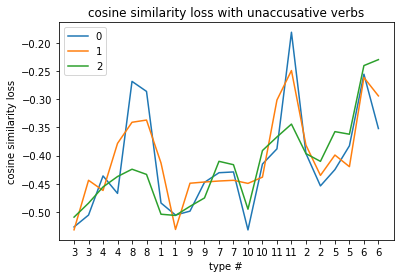

In [22]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Create pandas dataframe and save the cosine similaries loss in the previous steps to the dataframe
df=pd.DataFrame(np.array([verb_loss_before, verb_loss_middle, verb_loss_after]),
                 columns=['3', '3','4', '4','5', '5','6', '6', '1', '1', '2','2','7', '7','8', '8','9', '9','10','10', '11','11'])
df = df.T 
print(df) 

#sort the verb types based on the properties of constructions
df.index=pd.Categorical(df.index,categories=['3',  '4', '8',  '1',  '9','7', '10','11', '2', '5','6'])
df=df.sort_index()
#df=df.sort_index()
#df=df.sort_values(df.columns[0])
print(df) 
# multiple line plots

df.plot(use_index=True)
plt.xticks(np.arange(len(df.index)), df.index)

#plt.xticks(df.index)
plt.xlabel('type #')
plt.ylabel('cosine similarity loss')


plt.title('cosine similarity loss with unaccusative verbs')
# show legend
plt.legend()

# show graph
plt.show()

The plot shows the cosine similarity loss with unaccusative verbs. Our prediction is that verbs in type #3,4,8 are should have low loss than verbs in type #2,5,6,11. And verbs in type #1,7,9,10 should be in the middle and show intermediate similairties loss. This prediction is based on our knowledge of those constructions. Our result generally matches this prediction because the verb types on the right sides (#2,5,6,11) are generally higher than the left sides (#3,4,8) , forming a slope. Moreover, with more occurrences of each sentence, this left-slanted slope becomes more obvious. This graph demonstrated our hypothesis at the beginning of the notebook. 

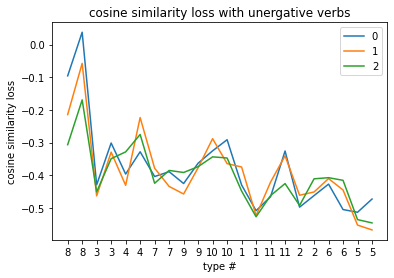

In [23]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Create pandas dataframe and save the cosine similaries loss in the previous steps to the dataframe
df_asp=pd.DataFrame(np.array([verb_loss_before_asp, verb_loss_middle_asp, verb_loss_after_asp]),
                 columns=['3', '3','4', '4', '5', '5','6', '6', '1', '1','2','2', '7', '7','8', '8','9', '9','10','10', '11','11'])
df_asp = df_asp.T 

#sort the verb types based on the properties of constructions
df_asp.index=pd.Categorical(df_asp.index,categories=['8','3', '4', '7', '9','10','1','11', '2', '6', '5'])
df_asp=df_asp.sort_index()
df_asp.plot(use_index=True)
plt.xticks(np.arange(len(df_asp.index)), df_asp.index)

#plt.xticks(df.index)
plt.xlabel('type #')
plt.ylabel('cosine similarity loss')
plt.title('cosine similarity loss with unergative verbs')
# show legend
plt.legend()

# show graph
plt.show()

This graph shows the cosine similarity loss with unergative verbs. Therefore the verb types on the left side, should be higher than the verbs types on the right side, contrarily to the above graph. The graph basically shows the same trend, and with more occurrences of sentences, the right-slanted slope becomes clearer. This result again desmontrated the hypothesis at the beginning of the notebook.

In [ ]:
# save the vectors for visualization
import io
vocab = model_simple_after.wv.vocab
out_v = io.open('vectors_word2vec.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata_word2vec.tsv', 'w', encoding='utf-8')

for item in model_simple_after.wv.vocab: 
  if index == 0:
    continue  # skip 0, it's padding.

  vec = model_simple_after.wv[item] 
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(str(item) + "\n")
out_v.close()
out_m.close()